In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time


In [ ]:
X_sequences = np.load("/content/drive/MyDrive/Colab Notebooks/pd_project/data/X_sequences.npy", allow_pickle=True)
user_keys = np.load("/content/drive/MyDrive/Colab Notebooks/pd_project/data/user_keys.npy", allow_pickle=True)

print("Shape of X_sequences:", X_sequences.shape)
print("Sample sequence shape:", X_sequences[0].shape)
print("Number of user keys:", len(user_keys))

Shape of X_sequences: (17727, 500, 3)
Sample sequence shape: (500, 3)
Number of user keys: 17727


In [ ]:
user_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pd_project/data/processed/combined_dataset.csv")
print("User Data Columns:", user_df.columns.tolist())
print(user_df.head())


User Data Columns: ['UserID', 'Gender', 'Parkinsons', 'Tremors', 'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other', 'AgeAtDiagnosis', 'UserKey', 'Hold time_mean', 'Hold time_std', 'Hold time_median', 'Flight time_mean', 'Flight time_std', 'Flight time_median', 'Latency time_mean', 'Latency time_std', 'Latency time_median']
       UserID  Gender  Parkinsons  Tremors  Sided    UPDRS     Impact  \
0  0EA27ICBLF  Female        True     True   Left  Unknown     Severe   
1  0QAZFRHQHW  Female       False    False  Right  Unknown  No Impact   
2  1HOEBIGASW    Male       False    False  Right  Unknown  No Impact   
3  1XNJCXS3EY    Male       False    False  Right  Unknown  No Impact   
4  2JTCBKUP8T    Male        True     True  Right  Unknown     Medium   

   Levadopa     DA   MAOB  ...     UserKey  Hold time_mean Hold time_std  \
0      True   True  False  ...  0EA27ICBLF       87.087552     25.204721   
1     False  False  False  ...  0QAZFRHQHW      102.873688     31.846867

In [ ]:
print("Unique users in keystroke data:", len(set(user_keys)))
print("Unique users in user dataset:", user_df["UserKey"].nunique())

missing_ages = user_df["AgeAtDiagnosis"].isna().sum()
print(f"Missing ages in user data: {missing_ages}")


Unique users in keystroke data: 217
Unique users in user dataset: 217
Missing ages in user data: 0


In [ ]:
user_age_map = dict(zip(user_df["UserKey"], user_df["AgeAtDiagnosis"]))
missing_users = [u for u in user_keys if u not in user_age_map]
print("Sequences without age info:", len(missing_users))


Sequences without age info: 0


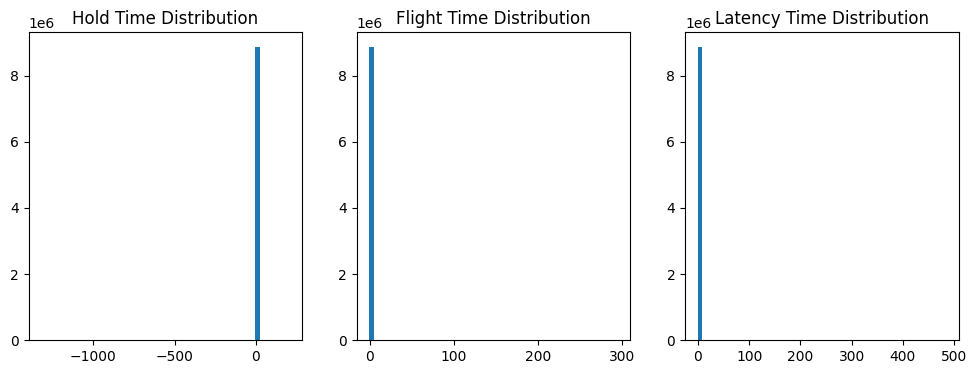

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(X_sequences[:,:,0].ravel(), bins=50)
plt.title("Hold Time Distribution")

plt.subplot(1,3,2)
plt.hist(X_sequences[:,:,1].ravel(), bins=50)
plt.title("Flight Time Distribution")

plt.subplot(1,3,3)
plt.hist(X_sequences[:,:,2].ravel(), bins=50)
plt.title("Latency Time Distribution")
plt.show()


In [ ]:
def add_age_to_sequences(X_sequences, user_keys, user_age_map):
    X_with_age = []
    for seq, user in zip(X_sequences, user_keys):
        age = user_age_map.get(user, np.nan)
        age_feature = np.full((seq.shape[0], 1), age)
        seq_with_age = np.concatenate([seq, age_feature], axis=1)
        X_with_age.append(seq_with_age)
    return np.array(X_with_age)

X_sequences_with_age = add_age_to_sequences(X_sequences, user_keys, user_age_map)
print("Final shape with Age:", X_sequences_with_age.shape)

Final shape with Age: (17727, 500, 4)


In [ ]:
SEQ_LEN = X_sequences_with_age.shape[1]
NUM_FEATS = X_sequences_with_age.shape[2]


In [ ]:



import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import time




class TimeGAN:
    def __init__(self, seq_len, n_features, hidden_dim=24, num_layers=3, learning_rate=5e-4):
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lr = learning_rate
        self._build_model()


    # Build RNN submodules

    def _make_rnn(self, name, output_dim=None):
        model = tf.keras.Sequential(name=name)
        for _ in range(self.num_layers):
            model.add(layers.GRU(self.hidden_dim, return_sequences=True))
            model.add(layers.TimeDistributed(
                layers.Dense(output_dim or self.hidden_dim, activation='sigmoid')
            ))
        return model

    def _build_model(self):
        # Components
        self.embedder = self._make_rnn('embedder')
        self.recovery = self._make_rnn('recovery', output_dim=self.n_features)
        self.generator = self._make_rnn('generator')
        self.supervisor = self._make_rnn('supervisor', output_dim=self.hidden_dim)
        self.discriminator = self._make_rnn('discriminator', output_dim=1)

        # Separate optimizers for each component
        self.opt_embedder = tf.keras.optimizers.Adam(self.lr)
        self.opt_generator = tf.keras.optimizers.Adam(self.lr)
        self.opt_discriminator = tf.keras.optimizers.Adam(self.lr)

        # Loss
        self.mse = tf.keras.losses.MeanSquaredError()


    # Training Function

    def train(self, data, epochs=400, batch_size=128, save_every=100):
        print(f" Training TimeGAN for {epochs} epochs ...")
        start_time = time.time()

        for epoch in range(1, epochs + 1):
            # Sample random batch
            idx = np.random.randint(0, data.shape[0], batch_size)
            X_batch = data[idx]


            # 1. Autoencoder step

            with tf.GradientTape() as tape:
                H = self.embedder(X_batch)
                X_tilde = self.recovery(H)
                e_loss = self.mse(X_batch, X_tilde)
            grads = tape.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
            self.opt_embedder.apply_gradients(zip(grads, self.embedder.trainable_variables + self.recovery.trainable_variables))


            # 2. Generator + Supervisor

            with tf.GradientTape() as tape:
                Z = np.random.uniform(0, 1, size=[batch_size, self.seq_len, self.hidden_dim])
                E_hat = self.generator(Z)
                H_hat_supervise = self.supervisor(E_hat)
                g_loss_u = self.mse(H_hat_supervise[:, :-1, :], H_hat_supervise[:, 1:, :])
                g_loss = g_loss_u + 0.1 * e_loss
            grads = tape.gradient(g_loss, self.generator.trainable_variables + self.supervisor.trainable_variables)
            self.opt_generator.apply_gradients(zip(grads, self.generator.trainable_variables + self.supervisor.trainable_variables))


            # 3. Discriminator

            with tf.GradientTape() as tape:
                H_real = self.embedder(X_batch)
                H_fake = self.generator(np.random.uniform(0, 1, size=[batch_size, self.seq_len, self.hidden_dim]))
                D_real = self.discriminator(H_real)
                D_fake = self.discriminator(H_fake)
                d_loss = tf.reduce_mean((D_real - 1) ** 2) + tf.reduce_mean(D_fake ** 2)
            grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_discriminator.apply_gradients(zip(grads, self.discriminator.trainable_variables))


            # Logging

            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{epochs} | e_loss: {e_loss:.4f} | g_loss: {g_loss:.4f} | d_loss: {d_loss:.4f}")




            if epoch % save_every == 0:
                self.generator.save_weights("timegan_generator.weights.h5")
                self.recovery.save_weights("timegan_recovery.weights.h5")


        elapsed = (time.time() - start_time) / 60
        print(f" Training completed in {elapsed:.2f} minutes")


    # Generate Synthetic Data

    def generate(self, n_samples=1000):
        Z = np.random.uniform(0, 1, size=[n_samples, self.seq_len, self.hidden_dim])
        E_hat = self.generator(Z)
        H_hat = self.supervisor(E_hat)
        X_hat = self.recovery(H_hat)
        return X_hat.numpy()

In [ ]:
import pandas as pd
import numpy as np

# Load user-level data
user_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pd_project/data/processed/combined_dataset.csv")
user_age_map = dict(zip(user_df["UserKey"], user_df["AgeAtDiagnosis"]))

def add_age_to_sequences(X_sequences, user_keys, user_age_map):
    X_with_age = []
    for seq, user in zip(X_sequences, user_keys):
        age = user_age_map.get(user, np.nan)
        age_feature = np.full((seq.shape[0], 1), age)
        seq_with_age = np.concatenate([seq, age_feature], axis=1)
        X_with_age.append(seq_with_age)
    return np.array(X_with_age)

# Apply to your sequence dataset
X_sequences_with_age = add_age_to_sequences(X_sequences, user_keys, user_age_map)

In [ ]:
print(X_sequences_with_age.shape)



(17727, 500, 4)


In [ ]:
SEQ_LEN = X_sequences_with_age.shape[1]
NUM_FEATS = X_sequences_with_age.shape[2]

timegan = TimeGAN(seq_len=SEQ_LEN, n_features=NUM_FEATS, hidden_dim=24, num_layers=3)
timegan.train(X_sequences_with_age, epochs=400, batch_size=128)


 Training TimeGAN for 400 epochs ...
Epoch 50/400 | e_loss: 971.8611 | g_loss: 97.1861 | d_loss: 0.4960
Epoch 100/400 | e_loss: 994.7485 | g_loss: 99.4748 | d_loss: 0.1581
Epoch 150/400 | e_loss: 906.1454 | g_loss: 90.6145 | d_loss: 0.0117
Epoch 200/400 | e_loss: 914.6284 | g_loss: 91.4628 | d_loss: 0.0072
Epoch 250/400 | e_loss: 875.9986 | g_loss: 87.5999 | d_loss: 0.0060
Epoch 300/400 | e_loss: 932.5165 | g_loss: 93.2516 | d_loss: 0.0053
Epoch 350/400 | e_loss: 903.6734 | g_loss: 90.3673 | d_loss: 0.0048
Epoch 400/400 | e_loss: 940.0266 | g_loss: 94.0027 | d_loss: 0.0045
 Training completed in 179.33 minutes


In [ ]:
# Create directory for saving models
import os
os.makedirs("/content/drive/MyDrive/Colab Notebooks/pd_project/models/timegan", exist_ok=True)

# Save important submodels
timegan.generator.save_weights("/content/drive/MyDrive/Colab Notebooks/pd_project/models/timegan/generator.weights.h5")
timegan.recovery.save_weights("/content/drive/MyDrive/Colab Notebooks/pd_project/models/timegan/recovery.weights.h5")
timegan.embedder.save_weights("/content/drive/MyDrive/Colab Notebooks/pd_project/models/timegan/embedder.weights.h5")

print(" TimeGAN models saved successfully.")


 TimeGAN models saved successfully.


In [ ]:
import numpy as np

# Load data
X_sequences = np.load("/content/drive/MyDrive/Colab Notebooks/pd_project/data/X_sequences.npy")
y_labels    = np.load("/content/drive/MyDrive/Colab Notebooks/pd_project/data/y_labels.npy")

# If labels are one-hot encoded → convert to class indices
if len(y_labels.shape) > 1 and y_labels.shape[1] > 1:
    y_classes = np.argmax(y_labels, axis=1)
else:
    y_classes = y_labels

    # Split into classes
    X_control    = X_sequences[y_classes == 0]      # Control (minority)
    X_parkinson  = X_sequences[y_classes == 1]      # Parkinson (majority)

    print("Control (minority):", X_control.shape)
    print("Parkinson (majority):", X_parkinson.shape)



Control (minority): (4868, 500, 3)
Parkinson (majority): (12859, 500, 3)


In [ ]:
minority_count = X_control.shape[0]
majority_count = X_parkinson.shape[0]

# Number of control samples to generate
n_to_generate = majority_count - minority_count
n_to_generate = max(0, n_to_generate)

print(f" Generating {n_to_generate} synthetic Control sequences...")

X_synth = timegan.generate(n_samples=n_to_generate)
print(" Synthetic Control shape:", X_synth.shape)


 Generating 7991 synthetic Control sequences...
 Synthetic Control shape: (7991, 500, 3)


In [ ]:
y_synth = np.zeros(X_synth.shape[0])  # 0 = Control


In [ ]:
X_aug = np.concatenate([X_control, X_synth, X_parkinson], axis=0)
y_aug = np.concatenate([
    np.zeros(X_control.shape[0]),     # Real Control
    y_synth,                          # Synthetic Control
    np.ones(X_parkinson.shape[0])     # Parkinson
])

print("Balanced dataset shape:", X_aug.shape, y_aug.shape)


Balanced dataset shape: (25718, 500, 3) (25718,)


In [ ]:
import numpy as np, os
save_dir = "/content/drive/MyDrive/Colab Notebooks/pd_project/data/processed/"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "X_aug.npy"), X_aug)
np.save(os.path.join(save_dir, "y_aug.npy"), y_aug)

print(" Saved augmented dataset successfully.")


In [ ]:
unique, counts = np.unique(y_aug, return_counts=True)
print("Class distribution after augmentation:")
for cls, cnt in zip(unique, counts):
    print(f"Class {int(cls)}: {cnt} samples")


Class distribution after augmentation:
Class 0: 12859 samples
Class 1: 12859 samples
